<a href="https://colab.research.google.com/github/DimpleB0501/SecureNPrivateAIScholarshipCodes/blob/master/GettingStartedWithColab/captureWebcamNMicrophoneColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Access webcam in Colab
From
https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=buJCl90WhNfq

In [0]:
import IPython

In [0]:
# Camera Capture
# Using a webcam to capture images for processing on the runtime.
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Access speech/ microphone in colab
from https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=rRhs_YyomPQh

In [4]:
!pip install ffmpeg-python

In [0]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [0]:
audio, sr = get_audio()

In [0]:
import matplotlib.pyplot as plt

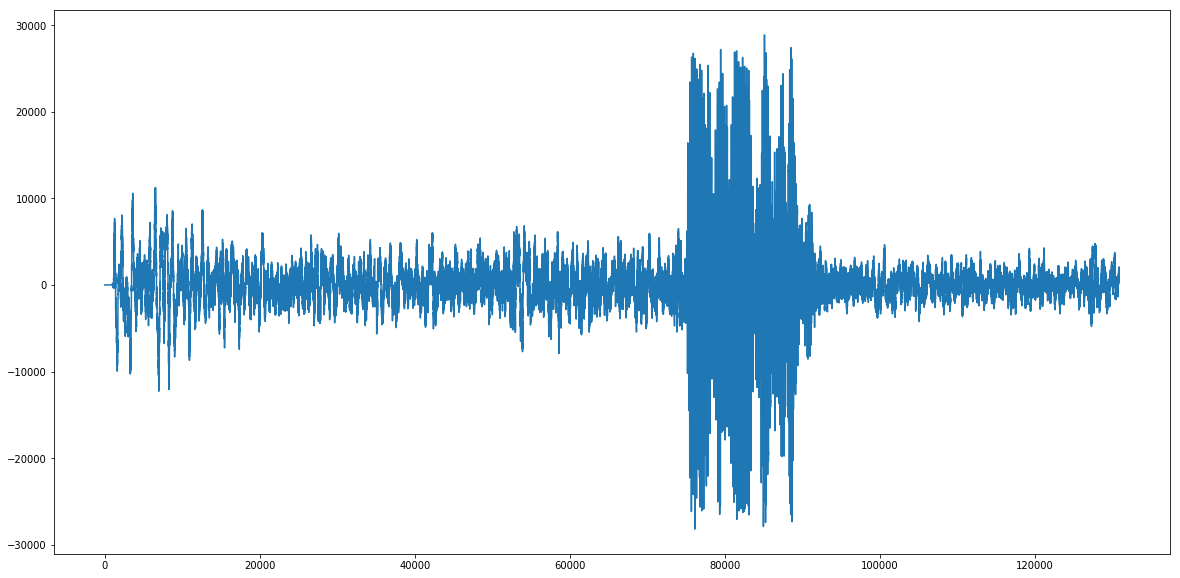

In [0]:
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()